## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distribution

import math
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import torchvision as tv
import torchvision.utils as vutils
import datasets
import visualize
from torchvision.utils import save_image

import os, time
import argparse

## Parameters

In [10]:
parser = argparse.ArgumentParser()

parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N', help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N', help='number of epochs to train (default: 10)')
parser.add_argument('-d', type=int, default=0)
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 1)')
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--device', type=str, default='cuda:0')

args = parser.parse_args("--epochs 100 --device cuda:0".split())

## Dataset

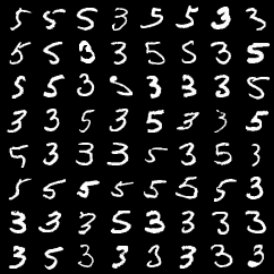

In [11]:
args.batch_size = 64
args.image_size = 32
args.label_list = [3,5]
    
def extract(dataloader, n):
    data_list, labels_list = [], []
    m = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            data = data.to(device)
            labels = labels.to(device)
            data_list.append(data)
            labels_list.append(labels)
            m += len(labels)
            if m>=n: break 
    data = torch.cat(data_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    return data, labels

train_loader, _, test_loader, _ = datasets.load_mnist(1.0, 1.0, args.batch_size, args.image_size, args.label_list)
imgs, labels = next(iter(test_loader))
args.n_batch = len(train_loader)

grid = tv.utils.make_grid(imgs[0:64], normalize=True)
tv.transforms.ToPILImage()(grid)

## VAE

In [19]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(32*32, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 32*32)

    def encode(self, x):
        n, D = x.size()
        x = x.view(len(x), -1)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def decode(self, z):
        n, d = z.size()
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))  

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 32*32))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_function(recon_x, x, mu, logvar):
    recon_x, x = recon_x/2+0.5, x/2+0.5
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 32*32), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD


def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    n_mc = 5
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        loss = torch.zeros(1).to(device)
        optimizer.zero_grad()
        # MC estimate of the loss
        for i in range(n_mc):
            recon_batch, mu, logvar = model(data)
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)
            loss_i = BCE + KLD
            loss += loss_i/n_mc
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

## Train

In [20]:
model = VAE().to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
device = args.device

for epoch in range(1, args.epochs + 1):
    train(epoch, model, train_loader, optimizer)
    if epoch%int(args.epochs/10)==0:
        with torch.no_grad():
            z = torch.randn(64, 20).to(device)
            x = model.decode(z).cpu()/2 + 0.5
            save_image(x.view(64, 1, 32, 32),'results/vae/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 228.2759
====> Epoch: 2 Average loss: 178.4529
====> Epoch: 3 Average loss: 171.0493
====> Epoch: 4 Average loss: 167.7127
====> Epoch: 5 Average loss: 165.7537
====> Epoch: 6 Average loss: 164.3779
====> Epoch: 7 Average loss: 163.3605
====> Epoch: 8 Average loss: 162.5410
====> Epoch: 9 Average loss: 161.8205
====> Epoch: 10 Average loss: 161.3962
====> Epoch: 11 Average loss: 160.9632
====> Epoch: 12 Average loss: 160.3454
====> Epoch: 13 Average loss: 160.0443
====> Epoch: 14 Average loss: 159.7667
====> Epoch: 15 Average loss: 159.3993
====> Epoch: 16 Average loss: 159.1697
====> Epoch: 17 Average loss: 158.9668
====> Epoch: 18 Average loss: 158.6504
====> Epoch: 19 Average loss: 158.5739
====> Epoch: 20 Average loss: 158.4284
====> Epoch: 21 Average loss: 158.0474
====> Epoch: 22 Average loss: 157.9226
====> Epoch: 23 Average loss: 157.9141
====> Epoch: 24 Average loss: 157.6496
====> Epoch: 25 Average loss: 157.4362
====> Epoch: 26 Average loss: 157.